In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.models import load_model
import datetime
from scipy.io import wavfile
from sklearn.preprocessing import StandardScaler
from pydub import AudioSegment
from scipy.signal import resample

In [3]:
uploaded_file_name = 'test.wav'
EXPECTED_SAMPLE_RATE = 44100


def convert_audio_for_model(user_file, output_file='test2.wav'):
    audio = AudioSegment.from_file(user_file, format="wav")
    audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
    audio.export(output_file, format="wav")
    return output_file


converted_audio_file = convert_audio_for_model(uploaded_file_name)

# # Loading audio samples from the wav file:
sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')

# 파형 출력 (그래프)

In [4]:
#! 수정 (오디오 정보, 파형 출력)
# 오디오 정보 출력.
duration = len(audio_samples)/sample_rate
print("data :", audio_samples)
print("Sample rate :", sample_rate)
print("Total duration :", duration)
print("Size of the input :", len(audio_samples))

data : [ 1025  3071  5121 ... -5628 -3588 -1534]
Sample rate : 44100
Total duration : 5.746938775510204
Size of the input : 253440


[ 1025  3071  5121 ... -5628 -3588 -1534]


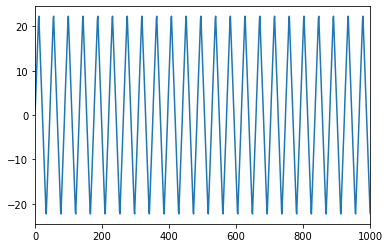

seq_len :  50


In [5]:
#! 수정 (변수명)
pd.DataFrame(audio_samples).to_csv("test.csv")
data = pd.read_csv('test.csv')
train_data = data['0'].values/1000
print(data['0'].values)
# 파형 그래프 출력
plt.plot(train_data)
plt.xlim(0,1000)
plt.show()
#! 수정 (50개 -> 5초간)
# # 5초 간의 데이터를 보고 다음을 예측

seq_len = 50  # 예측을 위한 데이터 수
prediction = 1 # 다음 예측할 데이터 수
print("seq_len : ", seq_len)
sequence_length = seq_len + prediction

# 정확한 예측를 위해 값들을 정규화
result = []
for index in range(len(train_data) - sequence_length):
    result.append(train_data[index: index + sequence_length])


# scaler = StandardScaler()
# normalized_data = scaler.fit_transform(np.array(result))

# normalized_data = []
# for i in range(len(result)):
#     # normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
#     print(i)
#     #! 수정 (표준화) -> 기존 정규화 했을때 분모가 0(조용한 상태일 때)이 되어 ZeroDivisionError 발생

#     # normalized_window = [
#     #     ((float(p) - float(min(result[i]))) / (float(max(result[i])) - float(min(result[i])))) for p in result[i]]
#     normalized_window = [
#         ((float(p) - np.array(result[i]).mean()) / np.array(result[i].std())) for p in result[i]]
#     normalized_data.append(normalized_window)

# print('끝')
# result = normalized_data

result = np.array(result)

In [42]:
# 트레이닝할 값과 테스트 값을 나눠줌
row = int(round(result.shape[0] * 0.1))
train = result[:row, :]

x_train = train[:, :-prediction]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -prediction]

x_test = result[row:, :-prediction]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -prediction]

print(x_train)
print(y_train)
print(x_test)
print(y_test)

[[[  1.025]
  [  3.071]
  [  5.121]
  ...
  [  7.168]
  [  9.215]
  [ 11.521]]

 [[  3.071]
  [  5.121]
  [  7.168]
  ...
  [  9.215]
  [ 11.521]
  [ 13.567]]

 [[  5.121]
  [  7.168]
  [  9.215]
  ...
  [ 11.521]
  [ 13.567]
  [ 15.616]]

 ...

 [[-16.129]
  [-14.078]
  [-12.035]
  ...
  [ -9.724]
  [ -7.684]
  [ -5.628]]

 [[-14.078]
  [-12.035]
  [ -9.724]
  ...
  [ -7.684]
  [ -5.628]
  [ -3.588]]

 [[-12.035]
  [ -9.724]
  [ -7.684]
  ...
  [ -5.628]
  [ -3.588]
  [ -1.534]]]
[13.567 15.616 17.666 ... -3.588 -1.534  1.025]
[[[ -9.724]
  [ -7.684]
  [ -5.628]
  ...
  [ -3.588]
  [ -1.534]
  [  1.025]]

 [[ -7.684]
  [ -5.628]
  [ -3.588]
  ...
  [ -1.534]
  [  1.025]
  [  3.071]]

 [[ -5.628]
  [ -3.588]
  [ -1.534]
  ...
  [  1.025]
  [  3.071]
  [  5.121]]

 ...

 [[-20.222]
  [-18.177]
  [-16.129]
  ...
  [-14.078]
  [-12.035]
  [ -9.724]]

 [[-18.177]
  [-16.129]
  [-14.078]
  ...
  [-12.035]
  [ -9.724]
  [ -7.684]]

 [[-16.129]
  [-14.078]
  [-12.035]
  ...
  [ -9.724]
  [ -7

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
2534/2534 [==============================] - 71s 28ms/step - loss: 2.8093 - val_loss: 0.0662
Epoch 2/5
2534/2534 [==============================] - 76s 30ms/step - loss: 0.0888 - val_loss: 0.0418
Epoch 3/5
2534/2534 [==============================] - 70s 28ms/step - loss: 0.0452 - val_loss: 0.0288
Epoch 4/5
2534/2534 [==============================] - 65s 26ms/step - lo

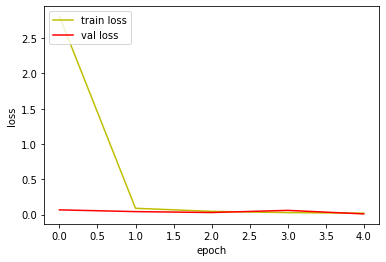

In [7]:
# # 모델 생성
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

# 트레이닝 값으로 학습
hist = model.fit(x_train, y_train, validation_data=(
    x_test, y_test), batch_size=10, epochs=5)

# 모델 저장
model.save('weight.h5')

# 5. 모델 학습 과정 표시하기
fig, loss_ax = plt.subplots()
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')
plt.show()

In [18]:
# 모델 로드
model = Sequential()
model = load_model('weight.h5')

In [43]:
# 테스트 값으로 예측
# x_test2 = result[:, :-prediction]
# x_test2 = np.reshape(x_test2, (x_test2.shape[0], x_test2.shape[1], 1))
# y_test2 = result[:, -prediction]
pred = model.predict(x_test)
pred
# print(pred)
# print(y_test2)
# print(len(pred))
# print(len(y_test2))

array([[ 2.9352376],
       [ 5.0020366],
       [ 7.146929 ],
       ...,
       [-7.6850204],
       [-5.695534 ],
       [-3.6113987]], dtype=float32)

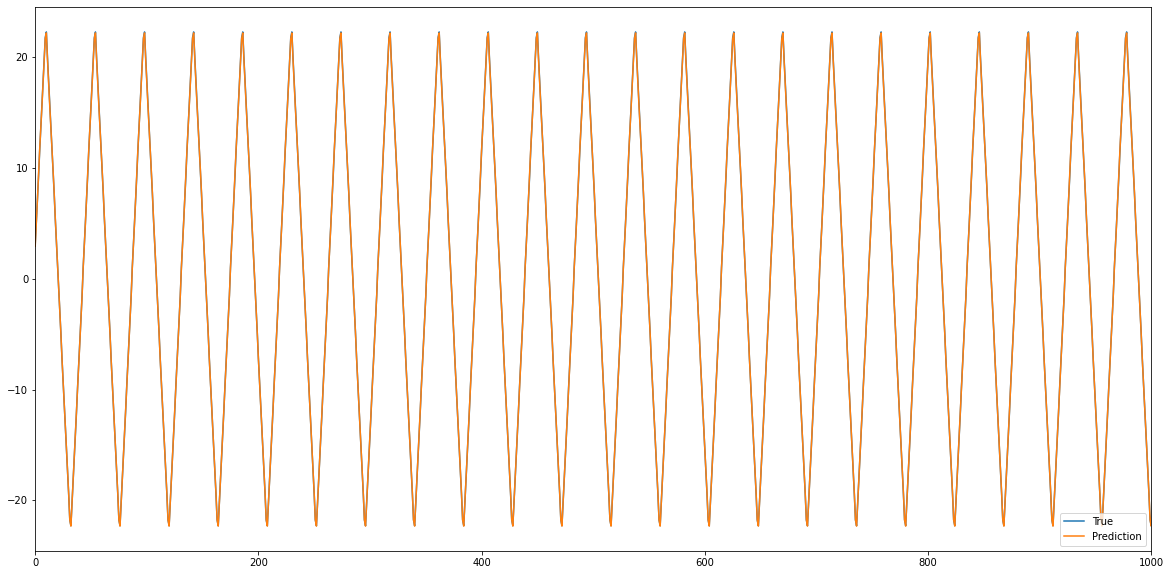

In [9]:
# 그래프
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.xlim(0,1000)
plt.show()

In [44]:
# 예측값을 wav로 출력

# audio_samples = np.array(audio_samples)
# print(type(audio_samples))
# print(type(pred))
pred = pred * 1000 / EXPECTED_SAMPLE_RATE
y_test = y_test * 1000 / EXPECTED_SAMPLE_RATE

In [45]:

wavfile.write("pred.wav",EXPECTED_SAMPLE_RATE,pred)
wavfile.write("y_test.wav",EXPECTED_SAMPLE_RATE,y_test)
print("end")

end
